# Projet de NLP : Prédiction du sexe à partir des données personnelles.

Marie-Olive THAURY

ENSAE 3A DSSS 

## Packages

In [1]:
#!pip install unidecode
#!pip install WordCloud

In [2]:
import pandas as pd
import seaborn as sns
import fonctions
from fonctions import find_index0, find_information, transform_sp
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

## Chargement et nettoyage des données

In [3]:
df = pd.read_csv('https://cloud.teklia.com/index.php/s/aGqfgcjrBrsjDfX/download/transcriptions_with_sex.csv')
#prop = pd.read_csv('https://cloud.teklia.com/index.php/s/N2rtRNMHzgqSxK3/download/firstname_with_sex.csv', sep=';')

In [4]:
df.head(5)

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


In [5]:
%%capture
patterns = ['firstname', 'link', 'occupation', 'employer', 'lob', 
            'birth_date', 'age', 'civil_status']

for pattern in patterns: 
    df[pattern + '0'] = df['groundtruth'].apply(lambda string: str.find(string, pattern + ': '))
    df[pattern + '1'] = df['groundtruth'].apply(lambda string: find_index0(string, pattern))

In [6]:
columns = ['firstname0', 'firstname1', 
           'link0', 'link1', 
           'occupation0', 'occupation1', 
           'employer0', 'employer1', 
           'lob0', 'lob1', 
           'birth_date0', 'birth_date1', 
           'age0', 'age1', 
           'civil_status0', 'civil_status1']

liste = []
for i in range(len(df)):
    liste.append(sorted(df[columns].iloc[i].to_list()))

In [7]:
%%capture
for pattern in patterns: 
    print(pattern)
    df[pattern] = ''
    df[pattern]= df['groundtruth'].apply(lambda string: find_information(pattern, string, df, liste))

In [8]:
df['occupation'] = df['occupation'].apply(lambda string: transform_sp(string))

In [9]:
df = df[['subject_line', 'groundtruth', 'sex', 'firstname', 
         'link', 'occupation', 'employer', 'lob', 'birth_date', 'age', 'civil_status']]
df.head(5)

,subject_line,groundtruth,sex,firstname,link,occupation,employer,lob,birth_date,age,civil_status
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,femme,marie,fille,idem,,,,30,
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,homme,louis-jean,chef,sans_profession,,,,67,
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,femme,marie,idem,idem,idem,,,15,
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,femme,marie,femme,,,rigny,1875,,
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,femme,marguerite,,,,,,78,


## Statistiques descriptives 

125
107
9


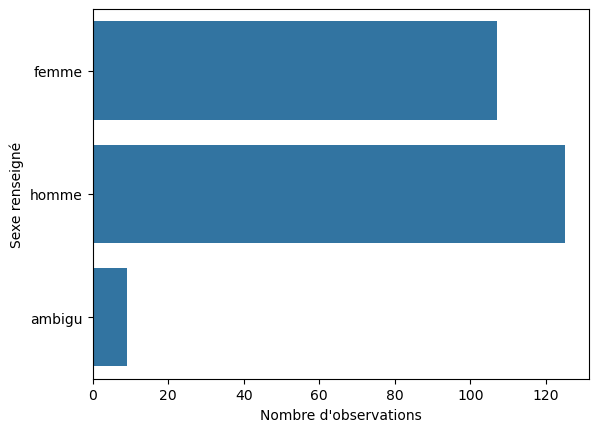

In [10]:
sns.countplot(data=df,y='sex', stat = 'count').set(ylabel='Sexe renseigné', xlabel="Nombre d'observations")

print(df.loc[(df['sex'] == 'homme')]['subject_line'].count())
print(df.loc[(df['sex'] == 'femme')]['subject_line'].count())
print(df.loc[(df['sex'] == 'ambigu')]['subject_line'].count())

In [11]:
df = df[df['sex'] != 'ambigu'] #on se restreint aux observations pour lesquelles le vrai label est clair 

In [12]:
df['employer' + '_exist'] = df['employer'].apply(lambda string: string != '')
df['lob' + '_exist'] = df['lob'].apply(lambda string: string != '')

[Text(0, 0.5, "La variable 'employer' est fournie (T/F)"),
 Text(0.5, 0, "Nombre d'observations")]

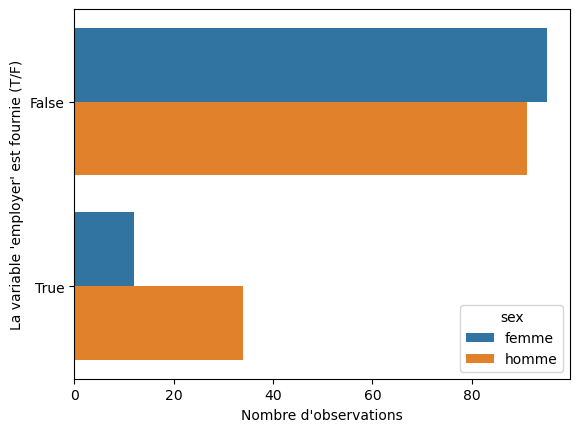

In [13]:
sns.countplot(data=df, y='employer_exist', stat = 'count', hue="sex").set(ylabel="La variable 'employer' est fournie (T/F)", xlabel="Nombre d'observations")

[Text(0, 0.5, "La variable 'lob' est fournie (T/F)"),
 Text(0.5, 0, "Nombre d'observations")]

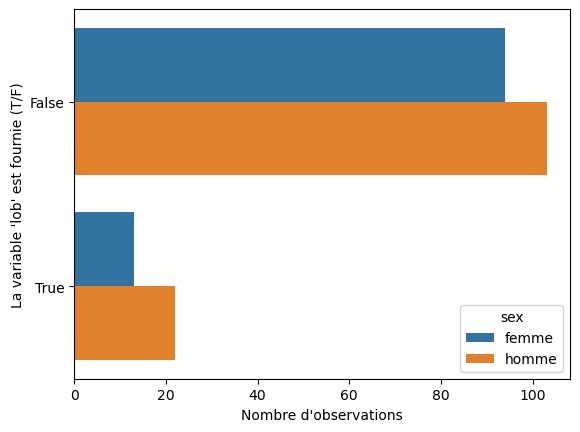

In [14]:
sns.countplot(data=df, y='lob_exist', stat = 'count', hue="sex").set(ylabel="La variable 'lob' est fournie (T/F)", xlabel="Nombre d'observations")

In [15]:
df.loc[((df['sex'] == 'homme') & (df['employer'] == ''))]['subject_line'].count() / df.loc[(df['sex'] == 'homme')]['subject_line'].count()

0.728

In [16]:
df.loc[((df['sex'] == 'femme') & (df['employer'] == ''))]['subject_line'].count() / df.loc[(df['sex'] == 'femme')]['subject_line'].count()

0.8878504672897196

In [17]:
df = df[['subject_line', 'groundtruth', 'sex', 'firstname', 
         'link', 'occupation']]
df['infos'] = df['firstname'] + ' ' + df['link'] + ' ' +  df['occupation']
#df.to_csv('df.csv', index=True)

In [18]:
df.head(5)

,subject_line,groundtruth,sex,firstname,link,occupation,infos
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,femme,marie,fille,idem,marie fille idem
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,homme,louis-jean,chef,sans_profession,louis-jean chef sans_profession
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,femme,marie,idem,idem,marie idem idem
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,femme,marie,femme,,marie femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,femme,marguerite,,,marguerite


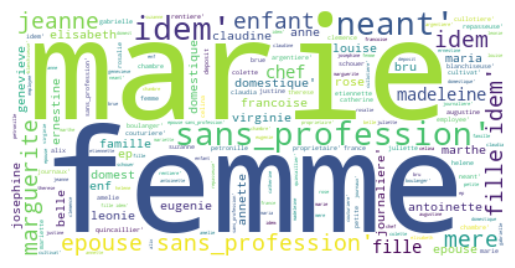

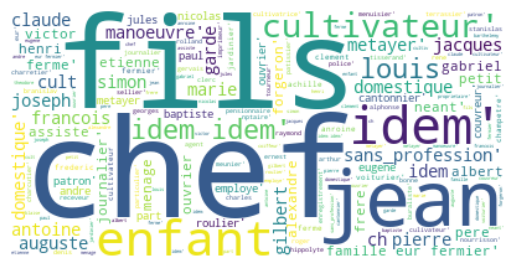

In [19]:
STOPWORDS = [x.strip() for x in open('stop_word_fr.txt').readlines()]

for sexe in ['femme', 'homme']:
    wc = WordCloud(background_color="white", repeat=True, stopwords = STOPWORDS, random_state= 2024) 
    wc.generate(str(df.loc[df['sex'] == sexe].infos.values))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Modèle

In [20]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2024)
X_train = df_train['infos']
y_train = df_train['sex']

X_test = df_test['infos']
y_test = df_test['sex']

In [21]:
vectorizer = CountVectorizer(max_features=1000)
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [22]:
clf = MultinomialNB()
clf.fit(X_train_counts, y_train)
y_predict = clf.predict(X_test_counts)

## Calcul de l'erreur du modèle 

In [23]:
print(clf.score(X_test_counts, y_test))
print(clf.score(X_train_counts, y_train))

0.9574468085106383
0.972972972972973


In [24]:
print(classification_report(list(y_test), list(y_predict), target_names=['femme', 'homme']))

              precision    recall  f1-score   support

       femme       0.96      0.96      0.96        23
       homme       0.96      0.96      0.96        24

    accuracy                           0.96        47
   macro avg       0.96      0.96      0.96        47
weighted avg       0.96      0.96      0.96        47



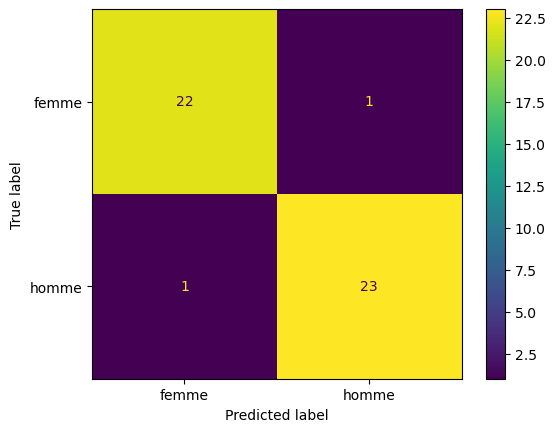

In [25]:
cm = confusion_matrix(y_test, y_predict, labels=['femme', 'homme'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['femme', 'homme'])
disp.plot()
plt.show()